In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [4]:
def build_dataset(words, block_size=3):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}   {Y.shape=}")
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)

X.shape=torch.Size([182625, 3])   Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3])   Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3])   Y.shape=torch.Size([22866])


In [45]:
g = torch.Generator().manual_seed(2147483647 + 10)

emb_dim = 10
n_hidden = 200
vocab_size = 27

# For deeper networks initialization is very important (deeper networks -> less forging for bad initialization)
C = torch.randn(vocab_size, emb_dim, generator=g)
W1 = torch.randn(emb_dim * block_size, n_hidden, generator=g) * (5/3) / (emb_dim*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # we are simplifying the work for the NN by already squashing the weights close to zero
b2 = torch.randn(vocab_size, generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of params: 11897


x: x.mean()=tensor(0.0026), x.std()=tensor(1.0126)
y: y.mean()=tensor(0.0040), y.std()=tensor(1.0360)


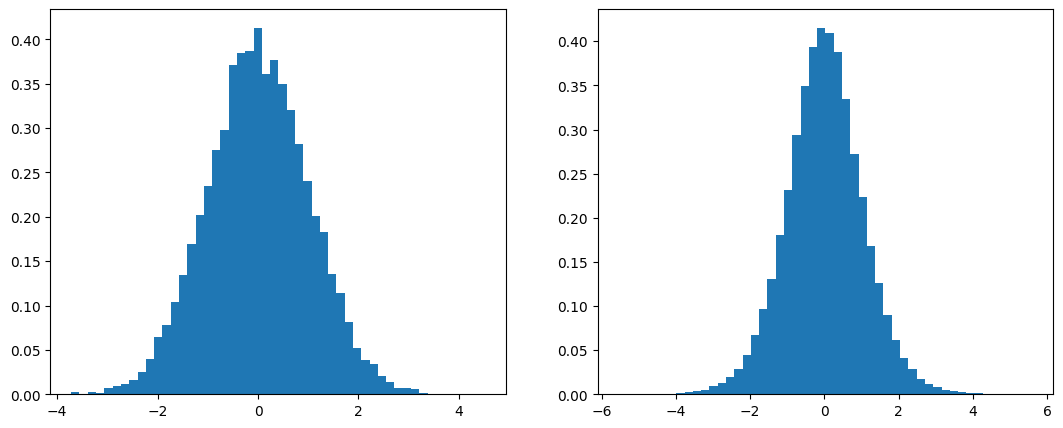

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # There is somekind of gain for each activation
z = torch.randn(200, 400)
y = x @ w

print(f"x: {x.mean()=}, {x.std()=}")
print(f"y: {y.mean()=}, {y.std()=}")

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.hist(x.view(-1), 50, density=True);
plt.subplot(132)
plt.hist(y.view(-1), 50, density=True);

In [25]:
epochs = 100_000
bs = 32
lossi = []

for i in range(epochs):

    idxs = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
    Xb, Yb = Xtr[idxs], Ytr[idxs]

    embs = C[Xb]

    # emb_resized = embs.view(embs.size()[0], -1)
    emb_resized = embs.view(-1, block_size*emb_dim)
    h_preact = emb_resized @ W1 + b1
    h = h_preact.tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    lr = 0.1 if i < 100_000 else 0.01

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())
    if i % 10_000 == 0:
        print(f"Loss [{i}]: {loss.item()}")
    break

Loss [0]: 3.293727159500122


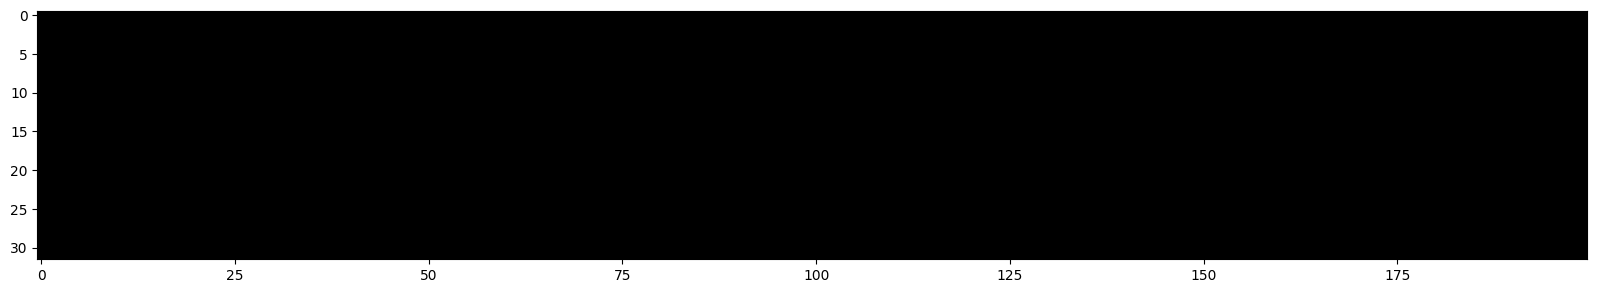

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray')

(array([  3.,   0.,   3.,   6.,  15.,  42.,  94., 168., 293., 438., 624.,
        786., 828., 770., 746., 566., 418., 281., 151.,  98.,  37.,  17.,
          8.,   4.,   4.]),
 array([-0.25106403, -0.23191941, -0.21277479, -0.19363016, -0.17448554,
        -0.15534092, -0.13619629, -0.11705167, -0.09790705, -0.07876242,
        -0.0596178 , -0.04047318, -0.02132855, -0.00218393,  0.01696069,
         0.03610532,  0.05524994,  0.07439456,  0.09353919,  0.11268381,
         0.13182843,  0.15097306,  0.17011768,  0.1892623 ,  0.20840693,
         0.22755155]),
 <BarContainer object of 25 artists>)

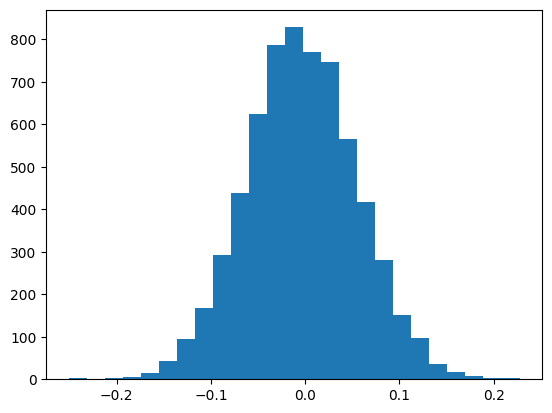

In [27]:
plt.hist(h.view(-1).tolist(), 25)

(array([  3.,   0.,   3.,   5.,  14.,  37.,  84., 172., 277., 418., 632.,
        777., 857., 788., 762., 567., 412., 281., 150.,  95.,  33.,  18.,
          7.,   4.,   4.]),
 array([-0.25654811, -0.23702195, -0.2174958 , -0.19796964, -0.17844348,
        -0.15891733, -0.13939117, -0.11986502, -0.10033886, -0.08081271,
        -0.06128655, -0.0417604 , -0.02223424, -0.00270808,  0.01681807,
         0.03634423,  0.05587038,  0.07539654,  0.09492269,  0.11444885,
         0.13397501,  0.15350116,  0.17302732,  0.19255347,  0.21207963,
         0.23160578]),
 <BarContainer object of 25 artists>)

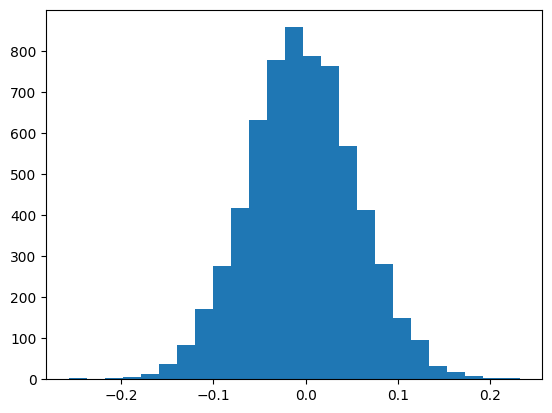

In [28]:
plt.hist(h_preact.view(-1).tolist(), 25)

In [11]:
@torch.no_grad()
def evaluate(evaluation_set):

    (Xc, Yc) = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[evaluation_set]

    embs = C[Xc]
    embs_resized = embs.view(embs.size()[0], -1)
    h = (embs_resized @ W1 + b1).tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yc)
    return loss

evaluate('test')


tensor(2.1021)